In [320]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import stardate as sd
import emcee
# from stardate.lhf import calc_bv, gyro_model_rossby, gyro_model

from isochrones import StarModel, get_ichrone
bands = ["B", "V", "J", "H", "K", "BP", "RP"]
mist = get_ichrone("mist", bands=bands)

Plot the lhf for a range of parameters for one of the simulated stars.

In [588]:
df = pd.read_csv("data/simulated_data.csv")
df = df.iloc[0]

fname = "0000_stardate.h5"
reader = emcee.backends.HDFBackend(fname)
samples = reader.get_chain()
lnprobs = reader.get_log_prob()
nsteps, nwalkers, ndim = np.shape(samples)
samps = np.reshape(samples, ((nsteps*nwalkers), ndim))
results = np.median(samps, axis=0)
print(results)

[ 3.01804416e+02  9.47698570e+00 -9.10686842e-02  6.51887782e+00
  5.24320188e-02]


In [589]:
teff_err = 25  # Kelvin
logg_err = .05  # dex
feh_err = .05  # dex
jmag_err = .01 # mags
hmag_err = .01  # mags
kmag_err = .01  # mags
B_err, V_err, bp_err, rp_err = .01, .01, .01, .01
parallax_err = .05  # milliarcseconds
prot_err = 1  # Days
BV_err = .01  # mags

# Set up the parameter dictionary.
iso_params = {"teff": (df["teff"], teff_err),
              "logg": (df["logg"], logg_err),
              "feh": (df["feh"], feh_err),
              "J": (df["jmag"], jmag_err),
              "H": (df["hmag"], hmag_err),
              "K": (df["kmag"], kmag_err),
              "B": (df["B"], B_err),
              "V": (df["V"], V_err),
              "G": (df["G"], bp_err),
              "BP": (df["BP"], bp_err),
              "RP": (df["RP"], rp_err),
              "parallax": (df["parallax"], parallax_err),
              "maxAV": .1}

mod = StarModel(mist, **iso_params)
args = [mod, df.prot, df.prot_err, None, None, False, False]  # the lnprob arguments]
lnparams = [df.eep, df.age, df.feh, np.log(df.d_kpc*1e3), df.Av]

from stardate.lhf import lnprob
    
# results = [435.85329441431645, 10.129259535998095, 0.33433233038395804, 6.016792599385651, 0.09578287162914803]  #69
# results = [443.4654382454131, 10.10951671752959, 0.07585148249477253, 6.852824639667813, 0.006064535155196636]  # 74
# results = np.array(results)

# inits = [466.442179691302, 9.783143924615793 ,0.04437935597266553 ,6.582800220670122 ,0.05112581468906065]  # 69
# inits = [442.3273995248113, 10.059660590480487, 0.14836682399774623, 6.885960128515226, 0.0017892251734095686]  # 74
# inits = np.array(inits)

print("truth = ", lnprob(lnparams, *args))
print("MCMC result = ", lnprob(results, *args))
print("inits = ", lnprob(inits, *args))

truth =  (-14.307167259432173, -16.30196905667401)
MCMC result =  (-14.550016227103825, -16.277688736603483)
inits =  (-160947.32019054017, -16.44975039451458)


In [590]:
age_probs, age_iso_probs = [], []
iso_args = [mod, None, None, None, None, True, False]
ages = np.linspace(8.8, 10.14, 1000)
for i in range(1000):
    lnparams = [df.eep, ages[i], df.feh, np.log(df.d_kpc*1e3), df.Av]
    age_probs.append(lnprob(lnparams, *args)[0])
    age_iso_probs.append(lnprob(lnparams, *iso_args)[0])

2.999294539321365


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.


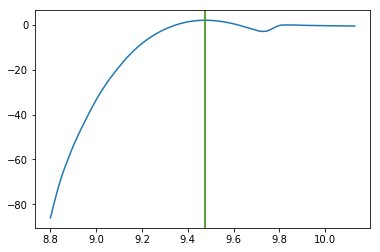

In [591]:
plt.plot(ages, np.array(age_probs)-np.array(age_iso_probs))
# plt.plot(ages, iso_probs)
plt.axvline(df.age, color="C1")
plt.axvline(results[1], color="C2")
print((10**df.age)*1e-9)

In [592]:
eep_probs, eep_iso_probs = [], []
eeps = np.linspace(250, 550, 1000)
for i in range(1000):
    lnparams = [eeps[i], df.age, df.feh, np.log(df.d_kpc*1e3), df.Av]
    eep_probs.append(lnprob(lnparams, *args)[0])
    eep_iso_probs.append(lnprob(lnparams, *iso_args)[0])

301.7439338714983


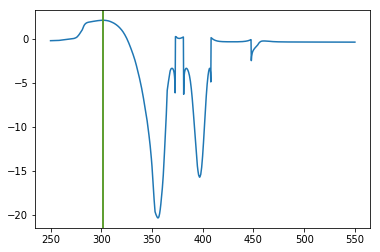

In [593]:
plt.plot(eeps, np.array(eep_probs) - np.array(eep_iso_probs))
plt.axvline(df.eep, color="C1")
plt.axvline(results[0], color="C2")
print(df.eep)

In [594]:
from tqdm import trange
nage, neep = 90, 110
ages = np.linspace(8.8, 10.14, nage)
eeps = np.linspace(250, 550, neep)

probs = np.zeros((nage, neep))
A, E = np.meshgrid(ages, eeps, indexing="ij")
for i in trange(nage):
    for j in range(neep):
        lnparams = [eeps[j], ages[i], df.feh, np.log(df.d_kpc*1e3), df.Av]
        probs[i, j] = lnprob(lnparams, *args)[0]

100%|██████████| 90/90 [00:04<00:00, 20.18it/s]


In [595]:
iso_probs = np.zeros((nage, neep))
for i in trange(nage):
    for j in range(neep):
        lnparams = [eeps[j], ages[i], df.feh, np.log(df.d_kpc*1e3), df.Av]
        iso_probs[i, j] = lnprob(lnparams, *iso_args)[0]

100%|██████████| 90/90 [00:03<00:00, 28.56it/s]


301.8044164094665 9.476985703468369


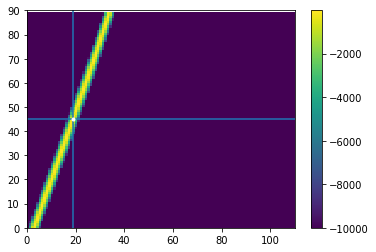

In [596]:
def find_nearest(x, array):
    ind = (np.argmin(abs(x - array)))
    return array[ind], ind

fig, ax = plt.subplots()
im = ax.pcolormesh(probs, vmin=-10000)# - iso_probs)
ylabels, xlabels = [], []

x, y = np.arange(neep), np.arange(nage)
_, age_ind = find_nearest(df.age, ages)
_, eep_ind = find_nearest(df.eep, eeps)
age_plot, ar_ind = find_nearest(results[1], ages)
eep_plot, er_ind = find_nearest(results[0], eeps)

print(results[0], results[1])

plt.axhline(y[age_ind])
plt.axvline(x[eep_ind])
fig.colorbar(im, ax=ax)
plt.plot(x[er_ind], y[ar_ind], "w.")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'EEP')

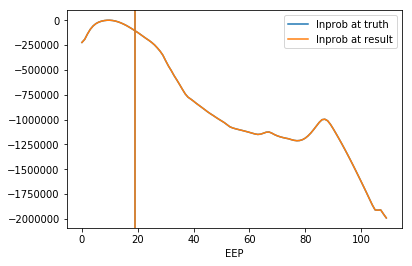

In [602]:
gyro_probs = probs - iso_probs
plt.plot(x, probs[eep_ind, :], label="lnprob at truth")
plt.plot(x, probs[er_ind, :], label="lnprob at result")
plt.axvline(x[eep_ind], color="C0")
plt.axvline(x[er_ind], color="C1")
plt.legend()
plt.xlabel("EEP")

Text(0.5, 0, 'Age')

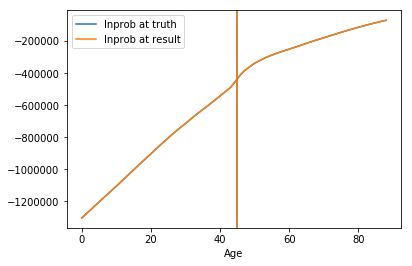

In [601]:
plt.plot(y, iso_probs[:, age_ind], label="lnprob at truth")
plt.plot(y, iso_probs[:, ar_ind], label="lnprob at result")
plt.axvline(y[age_ind], color="C0")
plt.axvline(y[ar_ind], color="C1")
plt.legend()
plt.xlabel("Age")

In [526]:
def find_nearest(x, array):
    return array[(np.argmin(abs(x - array)))]

def make_l_plot(df, i):
    print(df.eep, df.age)
    
    fname = "{}_stardate.h5".format(str(int(i)).zfill(4))
    reader = emcee.backends.HDFBackend(fname)
    samples = reader.get_chain()
    nsteps, nwalkers, ndim = np.shape(samples)
    samps = np.reshape(samples, ((nsteps*nwalkers), ndim))
    results = np.median(samps, axis=0)
    
    # Set up the parameter dictionary.
    iso_params = {"teff": (df["teff"], teff_err),
                  "logg": (df["logg"], logg_err),
                  "feh": (df["feh"], feh_err),
                  "J": (df["jmag"], jmag_err),
                  "H": (df["hmag"], hmag_err),
                  "K": (df["kmag"], kmag_err),
                  "B": (df["B"], B_err),
                  "V": (df["V"], V_err),
                  "G": (df["G"], bp_err),
                  "BP": (df["BP"], bp_err),
                  "RP": (df["RP"], rp_err),
                  "parallax": (df["parallax"], parallax_err),
                  "maxAV": .1}

    mod = StarModel(mist, **iso_params)
    args = [mod, df.prot, df.prot_err, None, None, False, False]  # the lnprob arguments]

    probs = np.zeros((nage, neep))
    for i in trange(nage):
        for j in range(neep):
            lnparams = [eeps[j], ages[i], df.feh, np.log(df.d_kpc*1e3), df.Av]
            probs[i, j] = lnprob(lnparams, *args)[0]
        
    iso_probs = np.zeros((nage, neep))
    for i in trange(nage):
        for j in range(neep):
            lnparams = [eeps[j], ages[i], df.feh, np.log(df.d_kpc*1e3), df.Av]
            iso_probs[i, j] = lnprob(lnparams, *iso_args)[0]

    diff = probs - iso_probs

    plt.clf()
    fig, ax = plt.subplots()
    im = ax.pcolormesh(probs)
    plt.colorbar(im, ax=ax)
    
    result_eep = find_nearest(results[0], eeps)
    result_age = find_nearest(results[1], ages)
    true_eep = find_nearest(df.eep, eeps)
    true_age = find_nearest(df.age, ages)
    x_result_ind, y_result_ind = result_eep == eeps, result_age == ages
    x_true_ind, y_true_ind = true_eep == eeps, true_age == ages
    x_result, y_result = np.arange(neep)[x_result_ind], np.arange(nage)[y_result_ind]
    x_true, y_true = np.arange(neep)[x_true_ind], np.arange(nage)[y_true_ind]
    
    plt.plot(x_result, y_result, "ko")
    plt.plot(x_true, y_true, "wo")
    plt.show()
    
    print(x_true)
    plt.clf()
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(eeps, probs[x_true[0], :])
    plt.plot(eeps, probs[x_result[0], :])
    mi, ma = min(probs[x_true[0], :]), max(probs[x_true[0], :])
    plt.axvline(df.eep)
    plt.axvline(results[0], color="C1")
    plt.xlabel("EEP")
    plt.ylim(mi,  ma+10)
    
    plt.subplot(1, 2, 2)
    plt.plot(ages, probs[:, y_true[0]])
    plt.plot(ages, probs[:, y_result[0]])
#     plt.axvline(y_true)
#     plt.axvline(y_result, color="C1")
    plt.axvline(df.age)
    plt.axvline(results[1], color="C1")
    plt.ylim(mi, ma+10)
    plt.xlabel("Age")
    plt.show()

In [527]:
df = pd.read_csv("data/simulated_data.csv")

  2%|▏         | 2/90 [00:00<00:04, 17.63it/s]

301.7439338714983 9.477019116816836


100%|██████████| 90/90 [00:03<00:00, 28.53it/s]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in subtract


<Figure size 432x288 with 0 Axes>

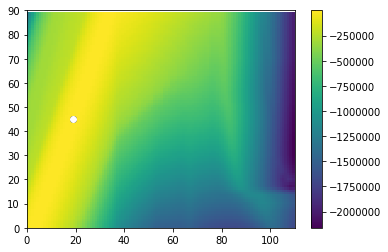

[19]


<Figure size 432x288 with 0 Axes>

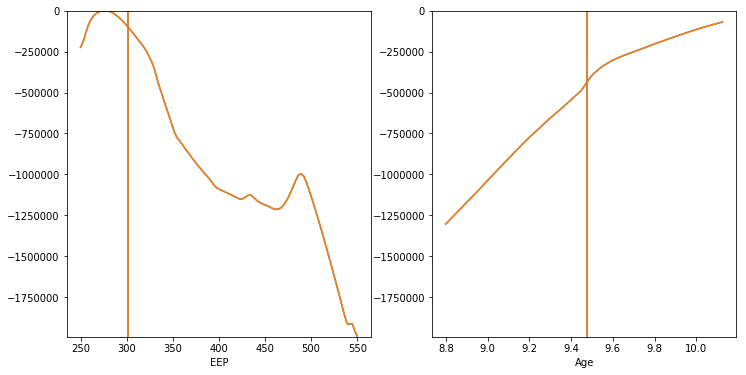

In [528]:
make_l_plot(df.iloc[0], 0)

  4%|▍         | 4/90 [00:00<00:05, 15.75it/s]

329.58125367115554 9.559615558434267


100%|██████████| 90/90 [00:03<00:00, 28.56it/s]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in subtract


<Figure size 432x288 with 0 Axes>

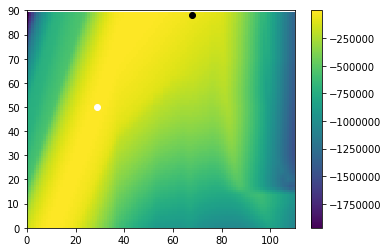

[29]


<Figure size 432x288 with 0 Axes>

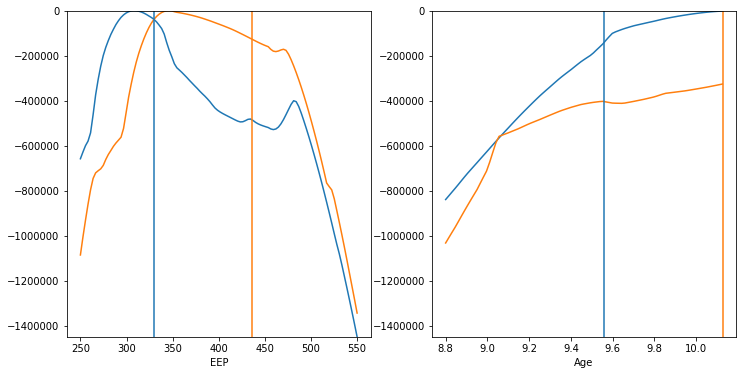

In [529]:
make_l_plot(df.iloc[69], 69)

  2%|▏         | 2/90 [00:00<00:04, 19.37it/s]

335.7317449638514 9.459863988936544


100%|██████████| 90/90 [00:03<00:00, 28.25it/s]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in subtract


<Figure size 432x288 with 0 Axes>

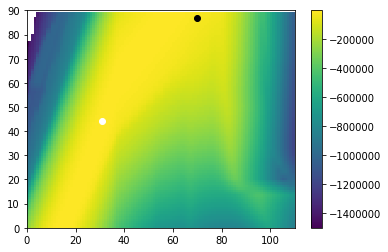

[31]


<Figure size 432x288 with 0 Axes>

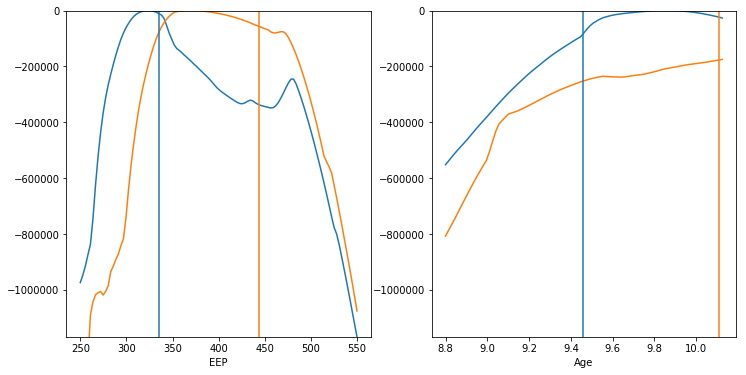

In [512]:
make_l_plot(df.iloc[74], 74)

In [ ]:
make_l_plot(df.iloc[193], 193)

In [ ]:
make_l_plot(df.iloc[202], 202)

304.7528526515486 9.84513227009255


100%|██████████| 90/90 [00:03<00:00, 27.63it/s]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in subtract


<Figure size 432x288 with 0 Axes>

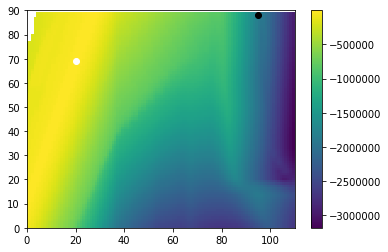

[20]


IndexError: index 95 is out of bounds for axis 0 with size 90

<Figure size 432x288 with 0 Axes>

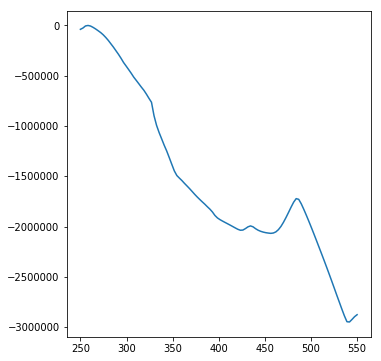

In [507]:
make_l_plot(df.iloc[209], 209)